<a href="https://colab.research.google.com/github/sujitpal/deeplearning-ai-examples/blob/master/blog_text_augment_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Augmenting to balance unbalanced text datasets (Part 1)

Idea is to investigate various techniques to augment unbalanced test datasets to balance them.

We use the unbalanced [SMA Spam Collection Dataset from Kaggle](https://www.kaggle.com/uciml/sms-spam-collection-dataset), which has 87% ham and 13% spam SMS texts.

In this notebook, we will use the [Google Universal Sentence Encoder](https://tfhub.dev/google/universal-sentence-encoder/4) to generate embeddings for our sentences.

### Setup



In [1]:
!pip install textattack

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow_hub as hub

from google.colab import drive

%matplotlib inline

In [3]:
# Mount Google Drive

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT)           # we mount the google drive at /content/drive

/content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
DATA_DIR = "/content/drive/MyDrive/nlp-deeplearning-ai-data"

SPAM_FILE = os.path.join(DATA_DIR, "spam.csv")

SPAM_TRAIN_FILE = os.path.join(DATA_DIR, "spam_train.tsv")
SPAM_VALID_FILE = os.path.join(DATA_DIR, "spam_valid.tsv")
SPAM_TEST_FILE = os.path.join(DATA_DIR, "spam_test.tsv")

SPAM_EMB_TRAIN_FILE = os.path.join(DATA_DIR, "spam_train_emb.tsv")
SPAM_EMB_VALID_FILE = os.path.join(DATA_DIR, "spam_valid_emb.tsv")
SPAM_EMB_TEST_FILE = os.path.join(DATA_DIR, "spam_test_emb.tsv")

SPAM_TA_TRAIN_FILE = os.path.join(DATA_DIR, "spam_train_ta.tsv")
SPAM_TA_EMB_TRAIN_FILE = os.path.join(DATA_DIR, "spam_train_ta_emb.tsv")

SPLIT_FRACS = [0.0, 0.7, 0.8, 1.0]

### Data Analysis

In [5]:
spam_df = pd.read_csv(SPAM_FILE, encoding="iso-8859-1")
spam_df = spam_df.drop(labels=spam_df.columns[2:], axis=1)
spam_df = spam_df.rename(columns={"v1": "label", "v2": "sentence"})

spam_df.head()

,label,sentence
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Class Distribution

In [6]:
spam_df["label"].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

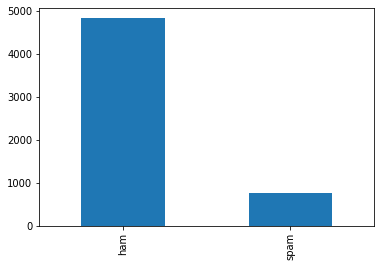

In [7]:
spam_df["label"].value_counts().plot(kind='bar');

### Data Splitting

Splits the input dataset into train, validation, and test sets, and writes out separate TSV files for each split.

In [8]:
def split_indices(orig_df, split_fracs):
  indices = orig_df.index.values
  np.random.shuffle(indices)
  splits = [int(x * len(indices)) for x in split_fracs]
  train_indices = indices[splits[0] : splits[1]]
  val_indices = indices[splits[1] : splits[2]]
  test_indices = indices[splits[2]: splits[3]]
  return train_indices, val_indices, test_indices


train_indices, val_indices, test_indices = split_indices(spam_df, SPLIT_FRACS)
len(train_indices), len(val_indices), len(test_indices)

(3900, 557, 1115)

In [9]:
spam_train_df = spam_df.iloc[train_indices]
spam_valid_df = spam_df.iloc[val_indices]
spam_test_df = spam_df.iloc[test_indices]

len(spam_train_df), len(spam_valid_df), len(spam_test_df)

(3900, 557, 1115)

In [10]:
spam_train_df.to_csv(SPAM_TRAIN_FILE, sep='\t')
spam_valid_df.to_csv(SPAM_VALID_FILE, sep='\t')
spam_test_df.to_csv(SPAM_TEST_FILE)

### Compute Sentence Embeddings

For each data split, we compute embeddings using the Google Universal Sentence Encoder (GUSE).

In [11]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

embeddings = embed([
    "The quick brown fox jumps over the lazy dog.",
    "I am a sentence for which I would like to get its embedding"])

len(embeddings), embeddings[0].numpy().shape

(2, (512,))

In [12]:
def compute_embeddings_and_write(input_df, model, output_file):
  if os.path.exists(output_file):
    print("Output file: {:s} already exists, skipping embedding".format(output_file))
    return
  fout = open(output_file, "w")
  fout.write("sentence\tlabel\tembedding\n")
  batch_size = 128

  num_recs = len(input_df)
  start, stop = 0, 0
  num_batches = (num_recs // batch_size) + 1

  for i in range(num_batches):
    stop = min(start + batch_size, num_recs)
    batch_df = input_df.iloc[start : stop]
    batch_labels = batch_df["label"].values
    batch_sents = batch_df["sentence"].values
    batch_embeddings = model(batch_sents)
    for label, sent, embedding in zip(batch_labels, batch_sents, batch_embeddings):
      embed_str = ",".join(["{:.7e}".format(x) for x in embedding.numpy().tolist()])
      fout.write("{:s}\t{:s}\t{:s}\n".format(sent, label, str(embed_str)))
    start = stop

  fout.close()


compute_embeddings_and_write(spam_train_df, embed, SPAM_EMB_TRAIN_FILE)
compute_embeddings_and_write(spam_valid_df, embed, SPAM_EMB_VALID_FILE)
compute_embeddings_and_write(spam_test_df, embed, SPAM_EMB_TEST_FILE)

## Augment using TextAttack

We augment the text for the training split only. In order to balance the dataset, for each `spam` record, we want to augment it with N additional variants provided by TextAttack, where the `ham` class is (N+1) times more common than `spam`.

**WARNING: This step takes a very long time to complete!**

We then compute and write out embeddings for the augmented training set.

In [13]:
from textattack.transformations import WordSwapRandomCharacterDeletion
from textattack.transformations import WordSwapQWERTY
from textattack.transformations import CompositeTransformation

from textattack.constraints.pre_transformation import RepeatModification
from textattack.constraints.pre_transformation import StopwordModification

from textattack.augmentation import Augmenter
from textattack.augmentation import CheckListAugmenter
from textattack.augmentation import WordNetAugmenter

In [14]:
num_major = len(spam_train_df[spam_train_df["label"] == "ham"])
num_minor = len(spam_train_df[spam_train_df["label"] == "spam"])

num_augmentations = int(num_major / num_minor)
num_major, num_minor, num_augmentations

(3355, 545, 6)

In [15]:
augmenters = []
# augment using mis-spellings
transformation = CompositeTransformation(
    [WordSwapRandomCharacterDeletion(), WordSwapQWERTY()])
# Set up constraints
constraints = [RepeatModification(), StopwordModification()]
# Create augmenter with specified parameters
augmenter = Augmenter(transformation=transformation, 
                      constraints=constraints, 
                      pct_words_to_swap=0.5, 
                      transformations_per_example=1)
augmenters.append(augmenter)
# augment using checklists
augmenter = CheckListAugmenter(pct_words_to_swap=0.2, 
                               transformations_per_example=2)
augmenters.append(augmenter)
# augment using wordnet
augmenter = WordNetAugmenter(pct_words_to_swap=0.2, 
                             transformations_per_example=2)
augmenters.append(augmenter)

In [16]:
def augment_sentence(sentence, augmenters):
  aug_sents = []
  for augmenter in augmenters:
    try:
      sentences = augmenter.augment(sentence)
      aug_sents.extend(sentences)
    except IndexError:
      continue
  return aug_sents

# self-test
augment_sentence(spam_train_df.iloc[0]["sentence"], augmenters)

2021-02-01 20:25:49,797 loading file /root/.flair/models/en-ner-conll03-v0.4.pt


["Ugh I do not wanna get out of bed. It's so warm.",
 "Ugh I don't wanna get out of bed. It's so warm.",
 "Ugh I don't wanna commence out of bed. It's so lovesome.",
 "Ugh ace don't wanna gravel out of bed. It's so warm."]

In [17]:
if os.path.exists(SPAM_TA_TRAIN_FILE):
  print("TextAttack augmented Spam Training file ({:s}) already exists, skipping")
else:
  fout = open(SPAM_TA_TRAIN_FILE, "w")
  fout.write("sentence\tlabel\n")

  num_processed, num_augmented = 0, 0
  for _, row in spam_train_df.iterrows():
    if num_processed % 1000 == 0:
      print("{:d} sentences processed, {:d} augmented"
        .format(num_processed, num_augmented))
    label = row.label
    sentence = row.sentence
    if label == "ham":
      fout.write("{:s}\t{:s}\n".format(sentence, label))
    else:
      # write out original sentence
      fout.write("{:s}\t{:s}\n".format(sentence, label))
      # augment and write out augmented sentences
      augmented_sents = augment_sentence(sentence, augmenters)
      for sent in augmented_sents:
        fout.write("{:s}\t{:s}\n".format(sent, label))
      num_augmented += 1
    num_processed += 1

  print("{:d} sentences processed, {:d} augmented, COMPLETE"
    .format(num_processed, num_augmented))
  fout.close()

0 sentences processed, 0 augmented
1000 sentences processed, 126 augmented
2000 sentences processed, 267 augmented
3000 sentences processed, 421 augmented
3900 sentences processed, 545 augmented, COMPLETE


In [18]:
spam_train_ta_df = pd.read_csv(SPAM_TA_TRAIN_FILE, sep='\t')
spam_train_ta_df = spam_train_ta_df.dropna()
spam_train_ta_df = spam_train_ta_df.reset_index()
spam_train_ta_df.head()

,index,sentence,label
0,0,Ugh I don't wanna get out of bed. It's so warm.,ham
1,1,Dear i have reache room,ham
2,2,I always chat with you. In fact i need money c...,ham
3,3,Yes just finished watching days of our lives. ...,ham
4,4,Nice.nice.how is it working?,ham


In [19]:
compute_embeddings_and_write(spam_train_ta_df, embed, SPAM_TA_EMB_TRAIN_FILE)

### Clean Up (After experiment)

In [20]:
# temp_files = [
#   SPAM_TRAIN_FILE,
#   SPAM_VALID_FILE,
#   SPAM_TEST_FILE,
#   SPAM_EMB_TRAIN_FILE,
#   SPAM_EMB_VALID_FILE,
#   SPAM_EMB_TEST_FILE,
#   SPAM_TA_TRAIN_FILE,
#   SPAM_TA_EMB_TRAIN_FILE
# ]
# for temp_file in temp_files:
#   if os.path.exists(temp_file):
#     os.unlink(temp_file)